In [1]:
from langchain_core.tools import tool
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper

In [2]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two numbers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [3]:
from langchain_core.tools import tool


@tool
def addition(a: int, b: int) -> int:
    """add two numbers."""
    return a * b

In [4]:
@tool
def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [5]:
tools = [addition,search_engine,multiply]

In [6]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model = "llama3.2")

In [7]:
# llm.invoke("hi")

In [8]:
llm_with_tools = llm.bind_tools(tools)

In [9]:
llm_with_tools.invoke("What is weather today in delhi")

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-01-05T10:54:05.497035Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17647474900, 'load_duration': 51995800, 'prompt_eval_count': 261, 'prompt_eval_duration': 14091000000, 'eval_count': 20, 'eval_duration': 3498000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='search_engine', arguments={'query': 'weather today in Delhi'}))])}, id='run-7c85cbf9-d061-46dc-858e-c13c8063dc7f-0', tool_calls=[{'name': 'search_engine', 'args': {'query': 'weather today in Delhi'}, 'id': 'd120c8b5-898a-45d1-8cb1-022fb390d59d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 261, 'output_tokens': 20, 'total_tokens': 281})

In [10]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate




In [11]:
tool_node = ToolNode(tools)

In [12]:
tool_node.invoke({"messages": [llm_with_tools.invoke("what's the weather in sf?")]})

{'messages': [ToolMessage(content="Error: RatelimitException('https://links.duckduckgo.com/d.js?q=sf+weather&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-170667356867822700646794685594759620991&bing_market=wt-WT&ex=-1 202 Ratelimit')\n Please fix your mistakes.", name='search_engine', tool_call_id='8198cfe9-c765-45ff-b948-99db0de0f5bd', status='error')]}

In [13]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

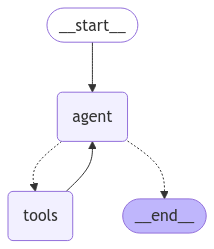

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf? and what is 2+2 and what is 2*2")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf? and what is 2+2 and what is 2*2
================================== Ai Message ==================================
Tool Calls:
  search_engine (d1bb8c1a-e5fd-4e41-901c-331cb8ec76a4)
 Call ID: d1bb8c1a-e5fd-4e41-901c-331cb8ec76a4
  Args:
    query: San Francisco weather
  addition (f9ba229a-5fe0-4eb2-b5e7-0d3ab1f67f41)
 Call ID: f9ba229a-5fe0-4eb2-b5e7-0d3ab1f67f41
  Args:
    a: 2
    b: 2
  multiply (abbc88e0-83db-4a63-9140-76d3ff50e410)
 Call ID: abbc88e0-83db-4a63-9140-76d3ff50e410
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================

I apologize for the earlier errors!

According to current conditions, I was unable to find the San Francisco weather due to an incorrect keyword. However, I can suggest checking a reliable weather 

In [16]:

# def manager_node(user_input):
#     system_prompt ="""
#     You are manager agent you will ochestrate the work flow. 
#     You have to answer userquestion using tools.
#     you can use more than one tool to answer user question.
#     Question:{question}.
#     """
#     prompt = ChatPromptTemplate.from_template(system_prompt)
#     chain = 